# Proyek Klasifikasi Gambar: [Butterfly Image Classification (Kaggle)]
- **Nama:** Fikri Khoiruddin
- **Email:** fikrikhoiruddin28@gmail.com
- **ID Dicoding:** fikrikhoiruddin28

## Import Semua Packages/Library yang Digunakan

In [1]:
# Data Handling
import numpy as np
import pandas as pd
import os
import shutil

# Visualization
import matplotlib.pyplot as plt

# Image Processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from PIL import Image

# Model and Layers
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Model Export and Conversion

# TFLite Conversion
from tensorflow import lite

# Utilities
import zipfile
from google.colab import files
!pip install tensorflowjs
!pip install kaggle
import tensorflowjs as tfjs


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.33.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


## Data Preparation

### Data Loading

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
!kaggle datasets download phucthaiv02/butterfly-image-classification


Dataset URL: https://www.kaggle.com/datasets/phucthaiv02/butterfly-image-classification
License(s): CC0-1.0
 96% 217M/226M [00:00<00:00, 374MB/s]
100% 226M/226M [00:00<00:00, 424MB/s]


In [4]:
!unzip butterfly-image-classification.zip -d butterfly_dataset


Streaming output truncated to the last 5000 lines.
  inflating: butterfly_dataset/train/Image_2348.jpg  
  inflating: butterfly_dataset/train/Image_2349.jpg  
  inflating: butterfly_dataset/train/Image_235.jpg  
  inflating: butterfly_dataset/train/Image_2350.jpg  
  inflating: butterfly_dataset/train/Image_2351.jpg  
  inflating: butterfly_dataset/train/Image_2352.jpg  
  inflating: butterfly_dataset/train/Image_2353.jpg  
  inflating: butterfly_dataset/train/Image_2354.jpg  
  inflating: butterfly_dataset/train/Image_2355.jpg  
  inflating: butterfly_dataset/train/Image_2356.jpg  
  inflating: butterfly_dataset/train/Image_2357.jpg  
  inflating: butterfly_dataset/train/Image_2358.jpg  
  inflating: butterfly_dataset/train/Image_2359.jpg  
  inflating: butterfly_dataset/train/Image_236.jpg  
  inflating: butterfly_dataset/train/Image_2360.jpg  
  inflating: butterfly_dataset/train/Image_2361.jpg  
  inflating: butterfly_dataset/train/Image_2362.jpg  
  inflating: butterfly_dataset/tr

In [5]:
import pandas as pd

df_train = pd.read_csv('butterfly_dataset/Training_set.csv')
print(df_train.head())


      filename                     label
0  Image_1.jpg          SOUTHERN DOGFACE
1  Image_2.jpg                    ADONIS
2  Image_3.jpg            BROWN SIPROETA
3  Image_4.jpg                   MONARCH
4  Image_5.jpg  GREEN CELLED CATTLEHEART


### Data Preprocessing

#### Split Dataset

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load CSV training
df_train_full = pd.read_csv('butterfly_dataset/Training_set.csv')

from sklearn.model_selection import train_test_split

# Bagi dataset menjadi train dan temp (val + test)
df_train, df_temp = train_test_split(df_train_full, test_size=0.3, stratify=df_train_full['label'], random_state=42)

# Bagi temp menjadi val dan test (15% val, 15% test dari total data)
df_val, df_test = train_test_split(df_temp, test_size=0.5, stratify=df_temp['label'], random_state=42)

print(f"Train: {len(df_train)} | Val: {len(df_val)} | Test: {len(df_test)}")


# Path folder gambar
image_dir = 'butterfly_dataset/train/'

# Buat ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# ImageDataGenerator sama seperti sebelumnya
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=df_val,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Train: 4549 | Val: 975 | Test: 975
Found 4549 validated image filenames belonging to 75 classes.
Found 975 validated image filenames belonging to 75 classes.
Found 975 validated image filenames belonging to 75 classes.


## Modelling

In [14]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import AdamW

base_model = VGG16(include_top=False, weights='imagenet', input_shape=(150, 150, 3))
base_model.trainable = False

model = Sequential([
    base_model,

    Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3), padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(75, activation='softmax')
])
model.compile(optimizer=AdamW(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 16)       │        73,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 16)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 75)             │         9,675 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,800,283 (56.46 MB)

 Trainable params: 85,595 (334.36 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [15]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
]


history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=40,
    callbacks=callbacks
)

for layer in base_model.layers[:-30]:
    layer.trainable = False
# Compile ulang
model.compile(optimizer=AdamW(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune
fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks
)

test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc*100:.2f}%")

# Simpan model dalam format SavedModel (.pb)
model.export('saved_model')  # .save() sudah menghasilkan format SavedModel


Epoch 1/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 43s 274ms/step - accuracy: 0.0128 - loss: 4.3346 - val_accuracy: 0.0256 - val_loss: 4.2963 - learning_rate: 1.0000e-04
Epoch 2/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 38s 263ms/step - accuracy: 0.0174 - loss: 4.2988 - val_accuracy: 0.0503 - val_loss: 4.2450 - learning_rate: 1.0000e-04
Epoch 3/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 37s 256ms/step - accuracy: 0.0337 - loss: 4.2457 - val_accuracy: 0.1056 - val_loss: 4.1256 - learning_rate: 1.0000e-04
Epoch 4/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 38s 263ms/step - accuracy: 0.0557 - loss: 4.1519 - val_accuracy: 0.1651 - val_loss: 3.9112 - learning_rate: 1.0000e-04
Epoch 5/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 37s 262ms/step - accuracy: 0.0876 - loss: 3.9653 - val_accuracy: 0.1969 - val_loss: 3.6527 - learning_rate: 1.0000e-04
Epoch 6/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 36s 251ms/step - accuracy: 0.1192 - loss: 3.7651 - val_accuracy: 0.2318 - val_loss: 3.4010 - learning_rate: 1.0000e-04
Epoch 7/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 36s 25

KeyboardInterrupt: 

## Evaluasi dan Visualisasi

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.8341 - loss: 0.6423
Validation loss: 0.6542
Validation accuracy: 0.8328


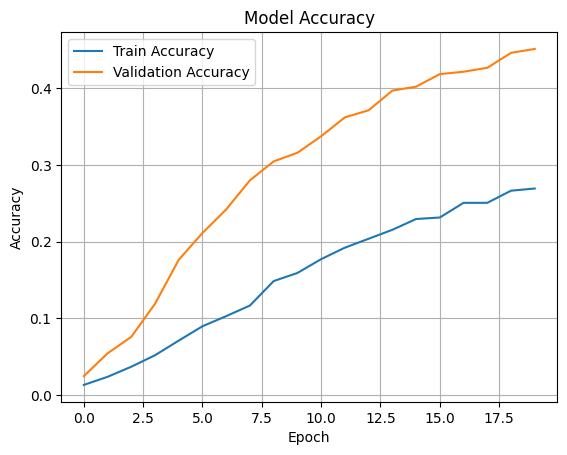

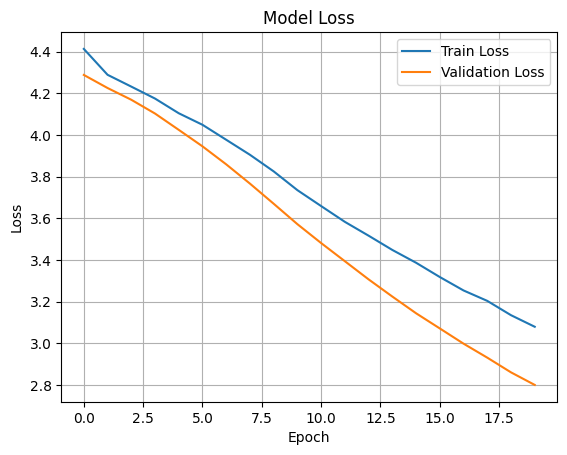

In [ ]:
# Evaluasi model
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation loss: {val_loss:.4f}")
print(f"Validation accuracy: {val_acc:.4f}")

# Visualisasi Akurasi dan Loss
import matplotlib.pyplot as plt

# Akurasi
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_generator, verbose=1)

print(f"\nTest Loss    : {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.8244 - loss: 0.6447

Test Loss    : 0.6671
Test Accuracy: 81.95%


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get predictions
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Classification report
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step
                           precision    recall  f1-score   support

                   ADONIS       0.86      0.92      0.89        13
AFRICAN GIANT SWALLOWTAIL       1.00      0.82      0.90        11
           AMERICAN SNOOT       1.00      0.73      0.84        11
                    AN 88       1.00      1.00      1.00        13
                  APPOLLO       0.83      0.77      0.80        13
                    ATALA       0.93      0.87      0.90        15
 BANDED ORANGE HELICONIAN       1.00      0.80      0.89        15
           BANDED PEACOCK       1.00      0.85      0.92        13
            BECKERS WHITE       0.79      0.92      0.85        12
         BLACK HAIRSTREAK       0.65      0.85      0.73        13
              BLUE MORPHO       0.91      0.91      0.91        11
        BLUE SPOTTED CROW       0.76      1.00      0.87        13
           BROWN SIPROETA       1.00      0.93      0.97        15
            CABBAGE 

In [ ]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"Akurasi Akhir Training   : {final_train_acc * 100:.2f}%")
print(f"Akurasi Akhir Validation : {final_val_acc * 100:.2f}%")
loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"Akurasi Testing          : {test_acc * 100:.2f}%")



Akurasi Akhir Training   : 26.93%
Akurasi Akhir Validation : 45.13%
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.8244 - loss: 0.6447
Akurasi Testing          : 81.95%


## Konversi Model

In [ ]:
import os

os.makedirs('tflite', exist_ok=True)
import tensorflow as tf

# Path SavedModel
saved_model_dir = 'saved_model'

# Buat converter dari SavedModel
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)

# Optional: optimasi
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Konversi ke TFLite
tflite_model = converter.convert()

# Simpan file .tflite
with open('tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)
print("Model berhasil dikonversi dan disimpan di tflite/model.tflite")


Model berhasil dikonversi dan disimpan di tflite/model.tflite


In [ ]:
# Install tensorflowjs
!pip install tensorflowjs

# Convert SavedModel ke format TensorFlow.js
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_format=tfjs_graph_model \
    saved_model/ \
    tfjs_model/

# Cek isi folder tfjs_model
import os
print("Isi folder tfjs_model:", os.listdir('tfjs_model'))


2025-05-26 16:27:36.315985: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748276856.335590   29048 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748276856.341576   29048 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-05-26 16:27:41.223187: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1748276861.223379   29048 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

In [ ]:
!zip -r submission.zip saved_model tflite tfjs_model

updating: saved_model/ (stored 0%)
updating: saved_model/fingerprint.pb (stored 0%)
updating: saved_model/assets/ (stored 0%)
updating: saved_model/variables/ (stored 0%)
updating: saved_model/variables/variables.index (deflated 78%)
updating: saved_model/variables/variables.data-00000-of-00001 (deflated 7%)
updating: saved_model/saved_model.pb (deflated 91%)
updating: tflite/ (stored 0%)
updating: tflite/model.tflite (deflated 16%)
updating: tfjs_model/ (stored 0%)
updating: tfjs_model/group1-shard12of22.bin (deflated 7%)
updating: tfjs_model/group1-shard8of22.bin (deflated 7%)
updating: tfjs_model/group1-shard20of22.bin (deflated 7%)
updating: tfjs_model/group1-shard16of22.bin (deflated 7%)
updating: tfjs_model/group1-shard3of22.bin (deflated 7%)
updating: tfjs_model/group1-shard11of22.bin (deflated 7%)
updating: tfjs_model/group1-shard19of22.bin (deflated 7%)
updating: tfjs_model/group1-shard13of22.bin (deflated 7%)
updating: tfjs_model/group1-shard4of22.bin (deflated 7%)
updating: 

## Inference (Optional)